# Topic 2.2: k-Means, k-Nearest Neighbors, decision trees

This notebook combines theory with exercises to support the understanding of k-Means clustering, the Nearest Neighbors classifier, and decision trees in comptuter-aided diagnostics. Implement all functions in the `code` folder of your cloned repository, and test it in this notebook after implementation by importing your functions to this notebook. Use available markdown sections to fill in your answers to questions as you proceed through the notebook.

**Contents:** <br>

1. [k-Means clustering](#kmeans)<br>
2. [Nearest neighbor classifier](#knnclassifier)<br>

    2.1 [Brain segmentation example](#brainseg)<br>
    
    
3. [Decision trees (theory)](#decisiontrees)<br>


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

<div id='kmeans'></div>
<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

## 1. k-Means clustering

$k$-means clustering is an unsupervised machine learning approach that aims to partition data points into $k$-clusters based on similarity among data points. The term clustering refers to the automatic recognition of different clumps of points in space.
Similarity between the data points is determined by the distance between them. Most often, the Euclidean distance is used, but other methods for similarity calculation exist (e.g. cosine similarity, average distance, etc.). The choice of similarity measure depends on the problem at hand. In principle, $k$-means clustering minimizes the distance between similar clusters, while maximizing the distance between dissimilar ones.

Given a clustering task, the $k$-means algorithm generally proceeds as follows:

<center width="100%"><img src="../reader/assets/kmeans_table.png" width="500"></center>

To better understand the principles of $k$-means clustering, navigate to this [Interactive Tool for Visualizing K-Means Clustering](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/), where you can also learn more details about the $k$-means algorithm properties, initialization strategies, and performance.

As you can see in [Exercise 1.1](#exercise1), specifying the `w_initial` parameter will help overcome the issue of differences in final clusters due to random initialization.

Summarizing the positives of using $k$-means algorithms for your classification tasks, this approach is easy to interpret, relatively fast, scalable, and guarantees convergence. On the contrary, the number of clusters must be pre-defined, which may be challenging; $k$-means cannot cope with nonlinear boundaries between separated clusters of data points; it is highly sensitive to outliers and it tends to be slower with increasing number of samples.


<div id='exercise1'></div>
<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div> 

### *Exercise 1.1*:
Generate Gaussian data `test_data` with 100 samples per class. To start the k-Means algorithm, we will first initialize some cluster centers for k-Means to start with. Define the number of clusters, e.g. `num_clusters = 2`. Now select `num_clusters` rows from `X` and store them in `w_initial`. You can verify by plotting the datasets on top of each other in different colors.

Cluster indices: [ 74 184]
Cluster centers: 
[[-0.24725892  1.11307541]
 [ 2.28110572  1.23451529]]


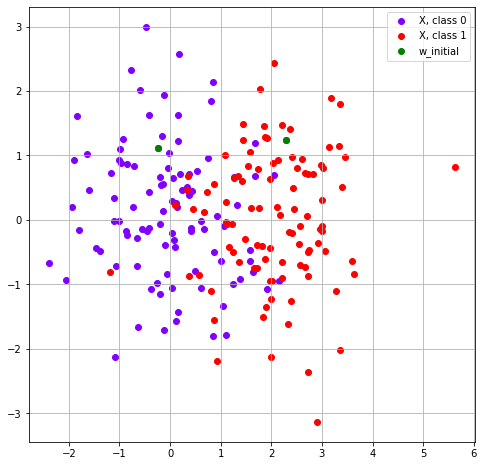

In [3]:
%matplotlib inline
import numpy as np
import scipy
import sys
sys.path.append("../code")
import matplotlib.pyplot as plt
import segmentation_util as util
from segmentation import generate_gaussian_data
N = 100
num_clusters = 2
test_data = generate_gaussian_data(N) # Generates 100 samples per Gaussian class
X, Y = test_data
ax = util.scatter_data(X,Y)
idx = np.random.randint(len(X), size=num_clusters)
w_initial = X[idx,:]
im2  = ax.scatter(w_initial[:,0], w_initial[:,1], color='g', label='w_initial')
plt.legend()
print('Cluster indices: {}'.format(idx))
print('Cluster centers: \n{}'.format(w_initial))

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div> 

### *Exercise 1.2*:
Assume these points are the cluster centers for your data. Calculate the minimum distances using the approach from the previous exercise and look at `min_index` to find out which cluster each sample belongs to.

In [5]:
D = scipy.spatial.distance.cdist(X, w_initial, metric='euclidean')
# For each row/sample in D, which column has the minimum value...
# (i.e. to which point in w_initial is this sample the closest)
min_index = np.argmin(D, axis=1)
print('min_index:\n{}'.format(min_index))
# Show these minimum distances in a vector
min_dist = np.empty(*min_index.shape)
for i in np.arange(len(D)):
    min_dist[i] = D[i, min_index[i]]
a = min_dist.dot(min_dist.T)
print(a)
# Calculate how many samples in X are closest to each of the samples in w_initial
b = np.empty(len(w_initial))
for j in np.arange(len(w_initial)):
    b[j] = len(np.where(min_index==j)[0])
print(b)

min_index:
[0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
574.9930674426226
[101.  99.]


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 1.3*:
Imagine that your cluster centers, while being randomly selected, were selected in a different order. You could achieve this with `w_initial = np.array([w_initial[1,:], w_initial[0,:]])`. Calculate the cluster assignments again and compare them to the previous result. If you want to use these results for segmentation of an image, what kind of problems do you expect? How could you solve this problem?

In [26]:
w_switched = np.array([w_initial[1,:], w_initial[0,:]])
D = scipy.spatial.distance.cdist(X, w_switched, metric='euclidean')
# For each row/sample in D, which column has the minimum value...
# (i.e. to which point in w_switched is this sample the closest)
min_index = np.argmin(D, axis=1)
print('min_index:\n{}'.format(min_index))
# Show these minimum distances in a vector
min_dist = np.empty(*min_index.shape)
for i in np.arange(len(D)):
    min_dist[i] = D[i, min_index[i]]
a = min_dist.dot(min_dist.T)
print(a)
# Calculate how many samples in X are closest to each of the samples in w_switched
b = np.empty(len(w_initial))
for j in np.arange(len(w_initial)):
    b[j] = len(np.where(min_index==j)[0])
print(b)

min_index:
[0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1]
512.4225230461032
[116.  84.]


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 1.4*:
To start optimization, we need to find out how good the current cluster assignment is. Use what you learned in the registration exercises, and in the course slides to complete the missing code in `cost_kmeans()` in `SECTION 1` of the `segmentation.py` module. You can check that this is working by creating good or bad cluster centers by hand, and then calculating the cost.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 1.5*:
Now that we have a cost function, we can optimize it with the same method as in the registration exercises. Use the code in `kmeans_demo()` in `SECTION 1` of the `segmentation_tests.py` module to see the final algorithm in action. What do you notice about the updates and the cost curve?

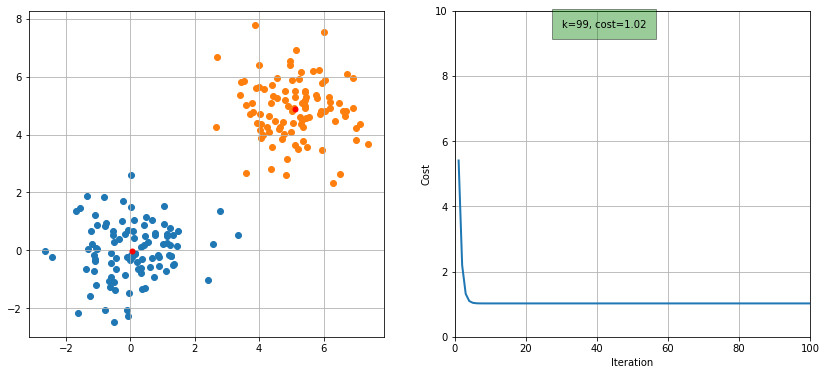

In [6]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import kmeans_demo, funX
from IPython.display import display, clear_output
        
kmeans_cost = kmeans_demo()

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 1.6*:
Now fill in the missing parts of code (parts of answers to previous questions) in `kmeans_clustering()` in `SECTION 1` of the `segmentation.py` module.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 1.7*:
Load a slice for the brain/non-brain task. Normalize the data and apply the clustering classifier to it. Visualize the results. Implement all of this in the `kmeans_clustering_test()` script in `SECTION 1` of the `segmentation_tests.py` module. Depending on the features you use, you could see something like this:

<center width="100%"><img src="../reader/assets/kmeans_example.png" width="800"></center>


In [ ]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import kmeans_clustering_test

#kmeans_clustering_test()

<div id='knnclassifier'></div>
<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

## 2. Nearest neighbor classifier

The $k$-Nearest Neighbor is a type of supervised learning algorithm used both in regression and classification tasks (e.g. to classify a CT or MRI scan as benign or malignant based on given features). Given $N$ training vectors, the $k$-NN algorithm tries to predict the class for the test data (e.g. a feature vector $\mathbf{c}$) by calculating the distance between $\mathbf{c}$ and other traning points. The variable $k$ represents the selected number of points which is closest to $\mathbf{c}$. 

<center width="100%"><img src="../reader/assets/k_nearest_neighbor.png" width="500"></center>

<font size="1"> Figure from [Antony Christopher on K-Nearest Neighbor](https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4)</font>

In classification tasks, $k$-NN algorithm is typically used to identify the category or class of a particular data point (or dataset) which is newly added to the space of two known categories, e.g. `A` and `B`. How does the algorithm determine the class or category? For a new example with features $x_{new} = [x_{1},x_{2}]$, predict the class $\hat{y_{new}}$ as follows:

1. Specify the amount of neighbors $k$ (e.g. $5$)
2. Compute the distance from the new point to the $k$ training samples. The most frequently used distance metric is the Euclidean distance calculated as $d(x_{new},x_{i})=\sqrt{(x_{new,1}-x_{i,1})^{2} + (x_{new,2}-x_{i,2})^{2}}$ (Note: another often used metric is [L1-distance](https://iq.opengenus.org/manhattan-distance/))
3. Count the number of data points in each category among the $k$ neighbors according to the Euclidean distance, sort them, and pick the nearest ones
4. Determine the class of the $k$ nearest training samples
5. Assign to $x_{new}$ the majority class of its nearest training samples (neighbors)
6. Algorithm has finished

Now, the question remains how to select the values of $k$. In general, the higher the value of $k$, the lesser the chance of erroneous classification. However, one has to keep in mind that every iteration of the distance calculation is computationally expensive. One cannot select the most applicable $k$-value via any pre-defined statistical methods. If we were to choose the optimal value of $k$ based on the performance on the training set, we would always select $k = 1$ since the training error would be 0. Hence, we need to choose $k$ based on the performance on an independent test set. The test set should be independent in the sense that the examples that it contains should by no means be related to the ones in the training set.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.1*:
First compute the (square) distance matrix between all samples in your Gaussian dataset. Find the minimum distances min dist and the indices of the corresponding columns min index as before. Can you already predict what values will be returned and why?

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.1*:
To make things a bit more exciting, generate two separate, small Gaussian datasets with different number of samples, but other than that the same parameters:

```python
train_data, train labels = generate_gaussian_data(2);
test_data, test labels = generate_gaussian_data(1); 
```

Classify the points in `test_data`, based on their distances `d` to the points in `train_data`. Write your implementation in `distance_classification_test()` in `SECTION 1` of the `segmentation_tests.py` module.

In [19]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import distance_classification_test

distance_classification_test()

Train data:
[[ 0.83930812  0.81613018]
 [-1.32459423  0.13026253]
 [ 2.64342427  1.97285797]
 [ 1.9433268   0.12701892]]
Test data:
[[-2.6113333   1.34939897]
 [ 1.48402625 -1.15203134]]
Distance matrix:
[[3.49160448 1.77256624 5.29161396 4.71583945]
 [2.07106766 3.0874952  3.33303721 1.35901677]]


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.2*:
What will the dimensions of `d` be? In which position `[row, column]` in the matrix is the distance of the last sample from `test_data`, to the first sample of `train_data`?

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.2*:
Implement the nearest neighbor functionality in the function `nn_classifier()` in `SECTION 1` of the `segmentation.py` module, which takes as input a training dataset with labels, and an unlabeled test dataset, and outputs the predicted labels for the test dataset.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.3*:
Now we will evaluate the classifier you implemented using the `nn_classifier_test_samples()` script in `SECTION 1` of the `segmentation_tests.py` module. You can inspect the predicted labels by displaying them side by side with the true labels. To count how many are incorrect, use `np.sum(true_labels != predicted_labels)`. How can you now calculate the error as a percentage? Implement the missing line of code in `classification_error()`.

In [10]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import nn_classifier_test_samples

nn_classifier_test_samples()

True labels:
[[0.]
 [1.]]
Predicted labels:
[[0.]
 [1.]]
Error:
0.0


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.4*:
Inspect the function `generate_train_test()` in `SECTION 1` of the `segmentation_tests.py` module, which generates a pair of training and test datasets. Modify the code (you only need to modify the parameters mu and sigma), such that the function can produce an "easy" dataset pair with low class overlap, where you expect the classification error to be low, and a "hard" dataset pair with high class overlap, where you expect the classification error to be high. Verify this using `nn_classifier()` and `classification_error()`. Write your implementation in `easy_hard_data_classifier_test()` in `SECTION 1` of the `segmentation_tests.py` module.

For the answer, also list the parameters you used for the easy and hard settings.

In [16]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import easy_hard_data_classifier_test
easy_hard_data_classifier_test()

Easy dataset:
Error:
0.85
Hard dataset:
Error:
0.4


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.5*:
Add the functionality below to `knn_classifier()`, which is similar to `nn_classifier()` but includes an additional input `k`. Instead of finding only the minimum distance using `scipy.spatial.distance.cdist()` and `np.argmin()`, you now need to find `k` minimum distances, then make `k` predictions for the labels, and then combine the `k` predictions into a final label. The code for this is already given below (so you just need to copy+paste it):

```python
sort_ix = np.argsort(D, axis=1)
sort_ix_k = sort_ix[:,:k] # Get the k smallest distances
predicted_labels = train_labels[sort_ix_k]
predicted_labels = scipy.stats.mode(predicted_labels, axis=1)
```
You can find `knn_classifier()` in `SECTION 1` of the `segmentation.py` module.

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.3*:
To make sure you understand the code, assume that you have a training set of 10 samples, a test set of 5 samples, and you are using a 3-nearest neighbor classifier. What are the dimensions of the variables `sort_ix`, `sort_ix_k`, `predicted_labels_k` and `predicted_labels`?

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.6*:

Load your brain/not brain datasets for two different subjects (one subject for training, another one for testing). Subsample the training set to 100 samples. Look at the code in `knn_curve()` in `SECTION 1` of the `segmentation_tests.py` module, modify the values of `k`, and test the code several times. Note that to save time, the ***scikit-learn*** implementation of k-NN could be used.

In [ ]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import knn_curve

knn_curve()

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.4*:
Describe in your own words what the code does.

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.5*:
What would you say is a good value of k? You might want to repeat the above a few times to get a better estimate of the performance. How could you estimate the error at k = 100, without evaluating the classifier? Does a lower error always equal to higher Dice (and vice versa)?

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.6*:

Here, we combine $k$-NN classifiers trained on different subjects. This functionality is also already implemented for you in the function `segmentation_combined_knn()` in `SECTION 3` of the `segmentation.py` module. What would you expect from the results of this combined method, compared to training $k$-NN on only one subject? Test your hypothesis on one of the subjects. (You can use `segmentation_knn()` to do this, note that this function has an extra input, since you need to specify which training subject you want to use!)

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.7:*
What could you do if you wanted to combine more than four classifiers (giving different decisions) here, but you could only use a 5-NN classifier?

<font style="color:red">Type your answer here</font>

<div id='brainseg'></div>

### 2.1 Brain segmentation example
Create two datasets (same slice, different subjects) for the brain/not brain classification task. Downsample the training set to 1000 pixels, this will save time during calculations. The test set should not be downsampled.

In [ ]:
%matplotlib inline
import sys
sys.path.append("../code")
import matplotlib.pyplot as plt
import numpy as np
import segmentation_util as util
from segmentation import generate_gaussian_data
# Subject 1, slice 1 is the train data
X, Y, feature_labels_train = util.create_dataset(1,1,'brain')
N = 1000
ix = np.random.randint(len(X), size=N)
train_data = X[ix,:]
train_labels = Y[ix,:]
# Subject 3, slice 1 is the test data
test_data, test_labels, feature_labels_test  = util.create_dataset(3,1,'brain')

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.1.1*:
Train the nearest neighbor classifier on train data, apply it to test data to get `predicted_labels`, and calculate the classification error. Implement your solution in the `nn_classifier_test_brains()` in `SECTION 1` of the `segmentation_tests.py` module.

In [ ]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import nn_classifier_test_brains

nn_classifier_test_brains()

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.1.1*:
What % of pixels are classified incorrectly? Run the code a few times, because of the data sampling you will get slightly different errors. Your answer to this question will probably be different from other groups, depending on the type of features you have previously implemented in the `extract_features` function.

<font style="color:red">Type your answer here</font>

<p><img src="../reader/assets/question_ico.png" width="42" height="42" style="float:right;;margin:-5px 5px"></p> 

### *Question 2.1.2*:
Now we know, from the classification error, how many pixels are predicted to be in the wrong class. The generated images also show what the classification results look like. This visualization was created by transforming the vector of predicted labels back into an image using `np.reshape()`. We have also loaded the ground truth mask in order to compare the result.

How would you describe the predicted mask? What kind of pixels are often classified incorrectly and why?

<font style="color:red">Type your answer here</font>

<div style="float:right;margin:-5px 5px"><img src="../reader/assets/todo_ico.png" width="42" height="42"></div>

### *Exercise 2.1.2*:
Implement the missing functionality in `dice_overlap()` in `SECTION 1` of the `segmentation.py` module and evaluate it on your segmentation. If you have a low classification error, you should have quite a high Dice score.

In [12]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_tests import nn_classifier_test_brains

nn_classifier_test_brains(testDice=True)

Error:
0.0359375
Dice coefficient:
0.944693812119269


<div style="float:right;margin:-5px 5px"><img src="../reader/assets/question_ico.png" width="42" height="42"></div>

### *Question 2.1.3*:
Can you think of an image where the error would be low, but the Dice score would be low, instead of high? If this is difficult to answer, try experimenting with different 10x1 vectors predicted labels and test labels that you fill in by hand, and vary the total number of zeros and ones in each vector.

<font style="color:red">Type your answer here</font>

<div id='decisiontrees'></div>
<div style="float:right;margin:-5px 5px"><img src="../reader/assets/read_ico.png" width="42" height="42"></div> 

## 3. Decision trees (theory)

Now that you have learnt about $k$-means and $k$-NN algorithms, it is time to have a look at a more powerful technique for classification and regression, the so-called $k$-dimensional decision tree classifiers. Decision trees are non-parametric supervised machine learning methods that aim to create a model that learns from data by repeatedly subdividing the feature space into smaller disjoint subsets to predict the value of the target variable. The input to the root of the tree is the sample to be classified. During the splitting process (based on comparisons), the decision tree incrementally grows, resulting in a tree with decision and leaf (terminal) nodes (subtrees). At the end of the process, each subset contains only samples with the same label. Decision trees work both with categorical, and continuous variables. 

One can also imagine a decision tree as a hierarchical flowchart diagram with initial node and terminal nodes representing the initial condition and classification decisions, respectively. Every decision node represents a point in feature space. In principle, the aim of a decision tree is to minimize the tree size to obtain the simplest possible explanation of the data. Normally, an error rate is accepted to avoid overfitting to the training data (this step is called *pruning*). 

For illustration, see the [documentation website of the scikit-learn Python package](https://scikit-learn.org/stable/modules/tree.html), which contains decision tree algorithms. 

It is common to use a splitting criterion to generate a tree from samples, e.g. the value distribution entropy in each subset. Ideally, a subset would only contain one label, i.e. its entropy would be minimal. Some examples of algorithms utilizing entropy are CART (Classification and Regression Trees), ID3, C4.5, and C5.

A great further explanation of $k$-dimensional trees together with graphical description of how the tree grows can be found [on this website](https://iq.opengenus.org/k-dimensional-tree/).







